In [14]:
import yfinance as yf
import pandas as pd

# Step 1: Define tickers and date range
tickers = ['KO', 'JNJ', 'HRL', 'ABBV']
start_date = '2020-01-01'
end_date = '2024-12-31'

# Step 2: Download full OHLCV data
data = yf.download(tickers, start=start_date, end=end_date)

# Step 3: Extract only the 'Close' prices from MultiIndex columns
close_prices = data.xs('Close', level='Price', axis=1)

# Step 4: Display the first few rows to confirm
print("Close Prices:")
print(close_prices.head())



[*********************100%***********************]  4 of 4 completed

Close Prices:
Ticker           ABBV        HRL         JNJ         KO
Date                                                   
2020-01-02  70.934250  38.315781  126.055176  46.749748
2020-01-03  70.260933  38.263905  124.595718  46.494705
2020-01-06  70.815430  38.281197  124.440300  46.477695
2020-01-07  70.411438  38.514664  125.200249  46.120628
2020-01-08  70.910469  38.557903  125.182945  46.205643


Ticker          ABBV       HRL       JNJ        KO
Date                                              
2020-01-03 -0.009492 -0.001354 -0.011578 -0.005455
2020-01-06  0.007892  0.000452 -0.001247 -0.000366
2020-01-07 -0.005705  0.006099  0.006107 -0.007683
2020-01-08  0.007087  0.001123 -0.000138  0.001843
2020-01-09  0.007708 -0.002242  0.002966  0.018215


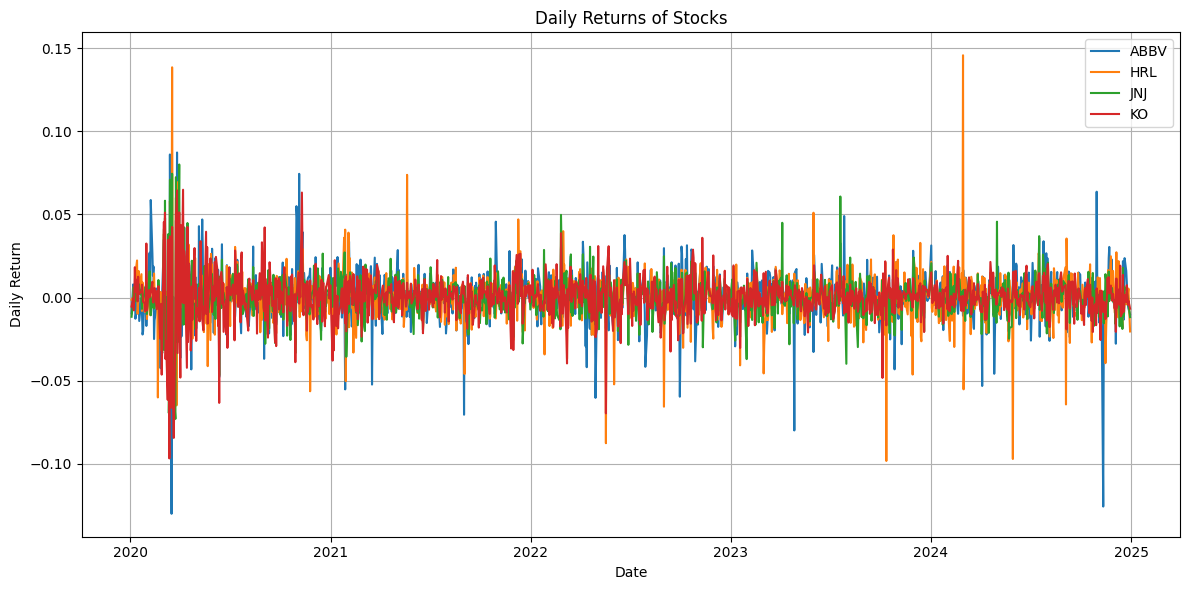

In [20]:
import matplotlib.pyplot as plt

#5: Calculate Daily Returns
daily_returns = close_prices.pct_change().dropna()

#6: Preview the first few Rows (Check)
print(daily_returns.head())

#7: Plot the daily returns for ALL assets
plt.figure(figsize=(12, 6))
for ticker in daily_returns.columns:
    plt.plot(daily_returns.index, daily_returns[ticker], label=ticker)

plt.title("Daily Returns of Stocks")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

#8: Generate random weights (for now)
num_assets = len(daily_returns.columns)
weights = np.random.random(num_assets)
weights /= np.sum(weights)  # normalize so they sum to 1

print("Random Portfolio Weights:")
for ticker, weight in zip(daily_returns.columns, weights):
    print(f"{ticker}: {weight:.2%}")

#9: Calculate expected annual return
mean_daily_returns = daily_returns.mean()
expected_return = np.dot(weights, mean_daily_returns) * 252  # 252 trading days/year

#10: Calculate portfolio volatility
cov_matrix = daily_returns.cov()
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

#11: Assume a risk-free rate for Sharpe Ratio
risk_free_rate = 0.02  # 2% assumed
sharpe_ratio = (expected_return - risk_free_rate) / portfolio_volatility

#12: Display results
print(f"\nExpected Annual Return: {expected_return:.2%}")
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Random Portfolio Weights:
ABBV: 4.71%
HRL: 3.23%
JNJ: 20.37%
KO: 71.69%

Expected Annual Return: 7.35%
Portfolio Volatility: 18.55%
Sharpe Ratio: 0.29


In [22]:
from scipy.optimize import minimize

#13: Define function to calculate negative Sharpe ratio
def neg_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    port_return = np.dot(weights, mean_returns) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe = (port_return - risk_free_rate) / port_volatility
    return -sharpe  # we want to maximize Sharpe, so minimize negative

#14: Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

#15: Run the optimization
opt_result = minimize(neg_sharpe, initial_guess,
                      args=(mean_daily_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

#16: Extract results
optimal_weights = opt_result.x
optimal_return = np.dot(optimal_weights, mean_daily_returns) * 252
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix * 252, optimal_weights)))
optimal_sharpe = (optimal_return - risk_free_rate) / optimal_volatility

#17: Display results
print("\n✅ Optimized Portfolio")
for ticker, weight in zip(daily_returns.columns, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

print(f"\nMax Sharpe Ratio: {optimal_sharpe:.2f}")
print(f"Expected Return: {optimal_return:.2%}")
print(f"Volatility: {optimal_volatility:.2%}")



✅ Optimized Portfolio
ABBV: 100.00%
HRL: 0.00%
JNJ: 0.00%
KO: 0.00%

Max Sharpe Ratio: 0.77
Expected Return: 20.99%
Volatility: 24.79%


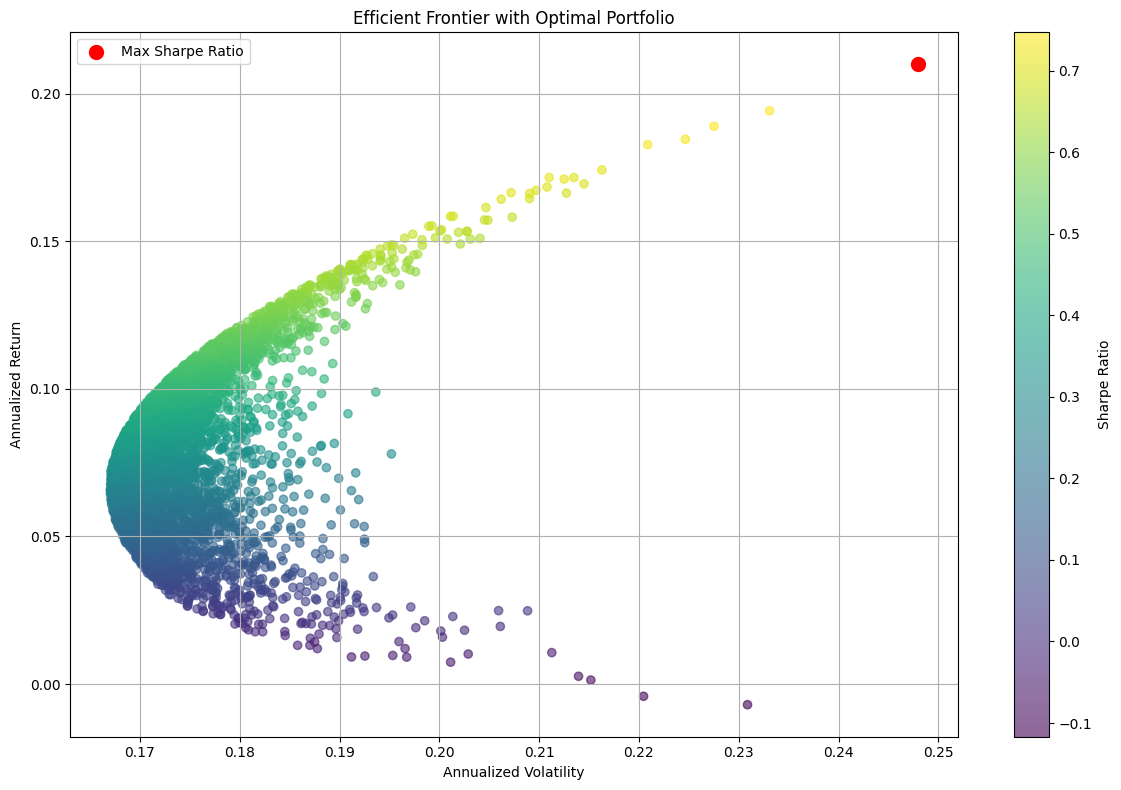

In [23]:
#18: Simulate many portfolios to plot the efficient frontier
num_portfolios = 5000
results = {
    'Returns': [],
    'Volatility': [],
    'Sharpe': [],
    'Weights': []
}

for _ in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    ret = np.dot(weights, mean_daily_returns) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe = (ret - risk_free_rate) / vol

    results['Returns'].append(ret)
    results['Volatility'].append(vol)
    results['Sharpe'].append(sharpe)
    results['Weights'].append(weights)

# Convert to DataFrame
import pandas as pd
df_results = pd.DataFrame(results)

#19: Plot the Efficient Frontier
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(df_results['Volatility'], df_results['Returns'], c=df_results['Sharpe'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')

# Highlight the Optimal Portfolio
plt.scatter(optimal_volatility, optimal_return, c='red', s=100, label='Max Sharpe Ratio')

plt.title('Efficient Frontier with Optimal Portfolio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
